# **Download the needed dataset**

In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip

--2020-10-03 22:32:24--  http://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip.2’

CCPP.zip.2          100%[===================>]   3.50M  2.48MB/s    in 1.4s    

2020-10-03 22:32:26 (2.48 MB/s) - ‘CCPP.zip.2’ saved [3674852/3674852]



In [2]:
!ls

CCPP  CCPP.zip	CCPP.zip.1  CCPP.zip.2	sample_data


In [3]:
!unzip CCPP.zip

Archive:  CCPP.zip
replace CCPP/Folds5x2_pp.ods? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **Preprocess the data**

In [4]:
import pandas as pd
import numpy as np
import cupy as cp
import itertools
import operator
import matplotlib.pyplot as plt


In [5]:
path = 'CCPP/Folds5x2_pp.xlsx'
training_data_x = pd.read_excel(path)
X_data = cp.array(training_data_x[['V']].to_numpy())
Y_data = cp.array(training_data_x[['PE']].to_numpy())
print(X_data)
print(Y_data)


[[41.76]
 [62.96]
 [39.4 ]
 ...
 [74.33]
 [69.45]
 [62.52]]
[[463.26]
 [444.37]
 [488.56]
 ...
 [429.57]
 [435.74]
 [453.28]]


In [6]:
X_train = X_data
Y_train = Y_data

In [7]:
# recieves the values of the input, output and the order "n" of the polynomial
def generate_system(x, y, n, lamb): 
  N = x.shape[0]
  X = cp.c_[np.ones(N),x]
  #generate all possible products of the input features to generate the needed matrix
  if n>1:
    col_indeces = list(range(x.shape[1]))
    indeces = []
    for i in range(2,n+1):
      indeces.extend(list(itertools.combinations_with_replacement(col_indeces,i)))

    for index in indeces:
      prod = x[:,index[0]]
      for col in index[1:]:
        prod = prod * x[:,col]
      X = cp.c_[X,prod]
  #compute the normal equation
  w = cp.dot(np.transpose(X), X)
  #the identity matrix is used for the L1 regularization
  w = w + lamb * cp.identity(X.shape[1])
  w = cp.linalg.inv(w)
  w = cp.dot(w,cp.transpose(X))
  w = cp.dot(w,y)
  cp.cuda.Stream.null.synchronize()
  return cp.asnumpy(w)

In [8]:
# returns the summation of the erros
def calc_error(y, fn):
    return np.sum(np.square(y - fn))

In [9]:
#returns the RMSE of the datapoints
def RMSE(y, fn, N):
    return np.sqrt(calc_error(y, fn)/N)

In [10]:
#Computes the new value given the weights
def predict(x, w, n =1):
    X = cp.c_[cp.ones(x.shape[0]),x]
      #generate all possible products of the input features to generate the needed matrix
    if n>1:
      col_indeces = list(range(x.shape[1]))
      indeces = []
      for i in range(2,n+1):
        indeces.extend(list(itertools.combinations_with_replacement(col_indeces,i)))
      for index in indeces:
        prod = x[:,index[0]]
        for col in index[1:]:
          prod = prod * x[:,col]
        X = cp.c_[X,prod]
    #compute the prediction
    y = cp.dot(X,w)
    cp.cuda.Stream.null.synchronize()
    return y

In [11]:
def train(x, y, n=1, lamb = 0):
    w =  generate_system(x, y, n, lamb)
    return w

In [12]:
#generate the 5 folds for the data
folds = 5
fold_size = int(X_train.shape[0]/folds)
X_train_folded = []
Y_train_folded = []

#normalize the data
X_train = (X_train-cp.min(X_train, axis=0))/(cp.max(X_train, axis=0)-cp.min(X_train, axis=0))
Y_train = (Y_train-cp.min(Y_train))/(cp.max(Y_train)-cp.min(Y_train))


for x in range(5):
    X_train_folded.append(X_train[fold_size*x:fold_size*(x+1)])
    Y_train_folded.append(Y_train[fold_size*x:fold_size*(x+1)])
    
X_train_folded = cp.asarray(X_train_folded)
Y_train_folded = cp.asarray(Y_train_folded)

print(X_train_folded.shape)
print(Y_train_folded.shape)

(5, 1913, 1)
(5, 1913, 1)


In [13]:
max_deg = 20
errors_validation = {}
errors_train = {}


# 5 folds cross validation
for deg in range(1,max_deg+1):
    errors_validation[deg] = []
    errors_train[deg] = []

    for f in range(5):
        #get the training data 
        x_train_model = cp.concatenate( [X_train_folded[i] for i in range(5) if (i != f) ])
        y_train_model = cp.concatenate( [Y_train_folded[i] for i in range(5) if (i != f)] )
        # get the validation data
        x_val_model = cp.concatenate( [X_train_folded[i] for i in range(5) if (i == f) ])
        y_val_model = cp.concatenate( [Y_train_folded[i] for i in range(5) if (i == f)] )
        #compute the weights
        weights = cp.array(train(x_train_model, y_train_model, deg, 0.5) )
        # predict the values for the training and the validation data
        pred_val = predict(x_val_model, weights,deg)
        pred_train = predict(x_train_model, weights,deg)
        #compute the RMSE of each prediction
        err_val = RMSE(y_val_model, pred_val, y_val_model.shape[0])
        err_train = RMSE(y_train_model, pred_train, y_train_model.shape[0])
        #save the error for the analysis
        errors_validation[deg].append(cp.asnumpy(err_val))
        errors_train[deg].append(cp.asnumpy(err_train))

        print ('For validation, got RMSE= %f for deg %d and fold %d: ' % ( err_val, deg, f+1))
        print ('For testing, got RMSE= %f for deg %d and fold %d: \n' % ( err_train, deg, f+1))


For validation, got RMSE= 0.111820 for deg 1 and fold 1: 
For testing, got RMSE= 0.111482 for deg 1 and fold 1: 

For validation, got RMSE= 0.112816 for deg 1 and fold 2: 
For testing, got RMSE= 0.111230 for deg 1 and fold 2: 

For validation, got RMSE= 0.111620 for deg 1 and fold 3: 
For testing, got RMSE= 0.111536 for deg 1 and fold 3: 

For validation, got RMSE= 0.111827 for deg 1 and fold 4: 
For testing, got RMSE= 0.111480 for deg 1 and fold 4: 

For validation, got RMSE= 0.109674 for deg 1 and fold 5: 
For testing, got RMSE= 0.112014 for deg 1 and fold 5: 

For validation, got RMSE= 0.106843 for deg 2 and fold 1: 
For testing, got RMSE= 0.107553 for deg 2 and fold 1: 

For validation, got RMSE= 0.109397 for deg 2 and fold 2: 
For testing, got RMSE= 0.106805 for deg 2 and fold 2: 

For validation, got RMSE= 0.107403 for deg 2 and fold 3: 
For testing, got RMSE= 0.107354 for deg 2 and fold 3: 

For validation, got RMSE= 0.108046 for deg 2 and fold 4: 
For testing, got RMSE= 0.10717

In [14]:

#create the analysis for the errors obtained
def generate_analysis(errors):
  analysis = {}
  for k in errors:
      if k:
          tmp = np.array(errors[k])
          analysis[k] = ( np.average(tmp), np.std(tmp) )
  return analysis

In [15]:
validation_analysis = generate_analysis(errors_validation)
validation_analysis

{1: (0.11155135811753514, 0.0010273857079358705),
 2: (0.10737718104959766, 0.0013831137399646614),
 3: (0.10728853751297791, 0.0013082958133404199),
 4: (0.10733901763168177, 0.0012990924504699246),
 5: (0.10722895965714471, 0.0012984407561124917),
 6: (0.10714760133461196, 0.0012859517679588456),
 7: (0.10713773234342214, 0.0012715613678764394),
 8: (0.10715223199947319, 0.0012635774565638205),
 9: (0.10714982990572137, 0.0012630220963372124),
 10: (0.10711953751405923, 0.0012672462123836847),
 11: (0.10707030333088215, 0.0012732495343255787),
 12: (0.10701633399440753, 0.0012790054995215198),
 13: (0.10696874640762073, 0.0012835528131032992),
 14: (0.1069332265480097, 0.0012866677078852402),
 15: (0.10691080575360194, 0.0012885182853779444),
 16: (0.10689958997228599, 0.0012894215023849997),
 17: (0.10689637513029711, 0.0012897050671012284),
 18: (0.10689778906987994, 0.0012896440135378101),
 19: (0.10690094344758347, 0.0012894416769899395),
 20: (0.10690370705834132, 0.001289233231

In [16]:
training_analysis = generate_analysis(errors_train)
training_analysis

{1: (0.11154848583501067, 0.0002558815549482593),
 2: (0.10735967863953914, 0.00037147845904662424),
 3: (0.10726566996970148, 0.00033874946046445135),
 4: (0.10731015246404685, 0.00034218139184648397),
 5: (0.10719735867866236, 0.0003396909833161574),
 6: (0.10711472577710339, 0.00033181622497380084),
 7: (0.10710347508091808, 0.0003271034048822275),
 8: (0.1071162644854837, 0.00032752428462926763),
 9: (0.10711207820036697, 0.0003310634884943117),
 10: (0.10708016626077677, 0.0003353229074986081),
 11: (0.10702957460953107, 0.00033885463199265903),
 12: (0.1069744864172523, 0.0003411664789753486),
 13: (0.10692593775288106, 0.0003423451583821024),
 14: (0.1068895337777724, 0.00034270953562631106),
 15: (0.10686625736446054, 0.0003425991731440523),
 16: (0.10685420622516002, 0.0003422818866841397),
 17: (0.10685020039464392, 0.00034193414908826757),
 18: (0.1068509097069271, 0.00034165470541202853),
 19: (0.1068534911699073, 0.0003414872060568097),
 20: (0.10685585109571431, 0.0003414

In [17]:
# return the best parameter in terms of the average error
def get_best_param(analysis, th = 1.2):
  sorted_accuracies = dict(sorted(analysis.items(), key= lambda item: (item[1][0],item[1],[1])))
  best_deg  = min(analysis.items(), key=operator.itemgetter(1))[0]
  return best_deg  
best_deg = get_best_param(validation_analysis)

In [18]:
best_deg

17

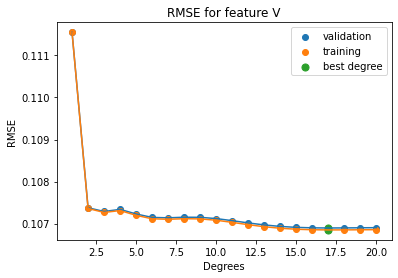

In [19]:
x_values_val = []
y_values_val = []
x_values_test = []
y_values_test = []

# plot the raw observations
for deg in range(1,max_deg+1):
  if deg != best_deg:
    x_values_val.append(deg)
    y_values_val.append(validation_analysis[deg][0])
    x_values_test.append(deg)
    y_values_test.append(training_analysis[deg][0])

plt.scatter(x_values_val, y_values_val, label = 'validation')
plt.scatter(x_values_test, y_values_test, label = 'training')
plt.scatter([best_deg]*2, [validation_analysis[best_deg][0], training_analysis[best_deg][0]], label='best degree',s = 50)

# plot the trend line with error bars that correspond to standard deviation
Mean_val = np.array([np.mean(value) for deg,value in sorted(errors_validation.items())])
Mean_train = np.array([np.mean(value) for deg,value in sorted(errors_train.items())])

plt.errorbar(list(range(1,max_deg+1)), Mean_val)
plt.errorbar(list(range(1,max_deg+1)), Mean_train)

plt.title('RMSE for feature V')
plt.xlabel('Degrees')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [20]:
#generate all the possible subsets of the features indeces
org_indeces = ['AT','V','RH','AP']
indeces = []
for i in range(1,5):
  indeces.extend(list(itertools.combinations(org_indeces,i)))
  
index = {}
for i,el in enumerate(indeces):
  index[i] = el

In [21]:
# compare all the possible subsets in terms of error for the linear case
errors_multi_linear_val = {}
errors_multi_linear_train = {}

for idx in indeces:
  indx = list(idx)
  #read the data
  X_data = training_data_x[indx].to_numpy()
  Y_data = training_data_x['PE'].to_numpy()
  X_train = cp.array(X_data)
  Y_train = cp.array(Y_data)
  #normalize the data
  X_train = (X_train-cp.min(X_train, axis=0))/(cp.max(X_train, axis=0)-cp.min(X_train, axis=0))
  Y_train = (Y_train-cp.min(Y_train))/(cp.max(Y_train)-cp.min(Y_train))
  #generate the needed 5 folds
  folds = 5
  fold_size = int(X_train.shape[0]/folds)
  X_train_folded = []
  Y_train_folded = []

  for x in range(5):
      X_train_folded.append(X_train[fold_size*x:fold_size*(x+1)])
      Y_train_folded.append(Y_train[fold_size*x:fold_size*(x+1)])
      
  X_train_folded = cp.asarray(X_train_folded)
  Y_train_folded = cp.asarray(Y_train_folded)
  
  errors_multi_linear_val[idx] = []
  errors_multi_linear_train[idx] = []
  #run the 5 folds cross validation
  for f in range(5):
    x_train_model = np.concatenate( [X_train_folded[i] for i in range(5) if (i != f) ])
    y_train_model = np.concatenate( [Y_train_folded[i] for i in range(5) if (i != f)] )
    
    x_val_model = np.concatenate( [X_train_folded[i] for i in range(5) if (i == f) ])
    y_val_model = np.concatenate( [Y_train_folded[i] for i in range(5) if (i == f)] )
    #calculate the weights
    weights = train(x_train_model, y_train_model,lamb=0.5) # L1 parameter is 0.5
    weights = cp.array(weights)
    
    pred_val = predict(x_val_model, weights,1)
    pred_train = predict(x_train_model, weights,1)

    err_val = RMSE(y_val_model, pred_val, y_val_model.shape[0])
    err_train = RMSE(y_train_model, pred_train, y_train_model.shape[0])
    errors_multi_linear_val[idx].append(cp.asnumpy(err_val))
    errors_multi_linear_train[idx].append(cp.asnumpy(err_train))
    print ('For validation, got RMSE= %f for fold %d: ' % ( err_val, f+1))
    print ('For testing, got RMSE= %f for fold %d: \n' % ( err_train, f+1))



For validation, got RMSE= 0.071106 for fold 1: 
For testing, got RMSE= 0.072050 for fold 1: 

For validation, got RMSE= 0.072476 for fold 2: 
For testing, got RMSE= 0.071704 for fold 2: 

For validation, got RMSE= 0.071144 for fold 3: 
For testing, got RMSE= 0.072040 for fold 3: 

For validation, got RMSE= 0.071815 for fold 4: 
For testing, got RMSE= 0.071872 for fold 4: 

For validation, got RMSE= 0.072812 for fold 5: 
For testing, got RMSE= 0.071617 for fold 5: 

For validation, got RMSE= 0.111820 for fold 1: 
For testing, got RMSE= 0.111482 for fold 1: 

For validation, got RMSE= 0.112816 for fold 2: 
For testing, got RMSE= 0.111230 for fold 2: 

For validation, got RMSE= 0.111620 for fold 3: 
For testing, got RMSE= 0.111536 for fold 3: 

For validation, got RMSE= 0.111827 for fold 4: 
For testing, got RMSE= 0.111480 for fold 4: 

For validation, got RMSE= 0.109674 for fold 5: 
For testing, got RMSE= 0.112014 for fold 5: 

For validation, got RMSE= 0.206681 for fold 1: 
For testing,

In [22]:
# generate the errors analysis
analysis_multi_linear_val = generate_analysis(errors_multi_linear_val)
analysis_multi_linear_train = generate_analysis(errors_multi_linear_train)

least_multi = get_best_param(analysis_multi_linear_val,1.1)
print(least_multi)


('AT', 'V', 'RH', 'AP')


In [23]:
# a function to take a tuple and convert it to a string
def convertTuple(tup): 
    str =  ''
    for el in tup:
      str += el+' '
    return str

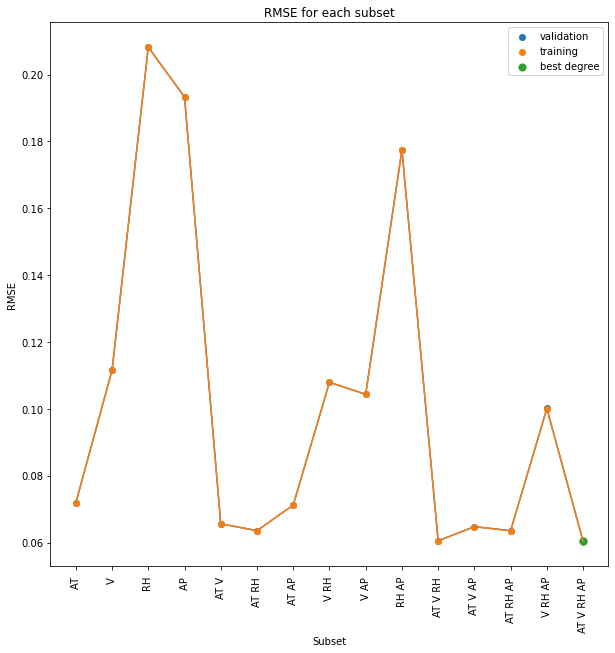

In [24]:
x_values_val = []
y_values_val = []
x_values_test = []
y_values_test = []


# plot the raw observations
for idx in indeces:
  if idx != least_multi:
    x_values_val.append(convertTuple(idx))
    y_values_val.append(analysis_multi_linear_val[idx][0])
    x_values_test.append(convertTuple(idx))
    y_values_test.append(analysis_multi_linear_train[idx][0])

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x_values_val, y_values_val, label='validation')
ax.scatter(x_values_test, y_values_test, label = 'training')
plt.setp(ax.get_xticklabels(), rotation = 90)

ax.scatter([convertTuple(least_multi)]*2, [analysis_multi_linear_val[least_multi][0], analysis_multi_linear_train[least_multi][0]], label='best degree', s = 50)

# plot the trend line with error bars that correspond to standard deviation
Mean_val = np.array([np.mean(value) for deg,value in errors_multi_linear_val.items()])
Mean_train = np.array([np.mean(value) for deg,value in errors_multi_linear_train.items()])

ax.errorbar(list(range(len(indeces))), Mean_val)
ax.errorbar(list(range(len(indeces))), Mean_train)

plt.title('RMSE for each subset')
plt.xlabel('Subset')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [26]:
#compare the effect of changing the degrees on the predicts but with all features
errors_multi_poly_val = {}
errors_multi_poly_train = {}
max_deg = 10
#load the data
X_data = training_data_x[['AT', 'V', 'RH', 'AP']].to_numpy()
Y_data = training_data_x['PE'].to_numpy()
X_train = cp.array(X_data)
Y_train = cp.array(Y_data)
#normalize the data
X_train = (X_train-cp.min(X_train, axis=0))/(cp.max(X_train, axis=0)-cp.min(X_train, axis=0))
Y_train = (Y_train-cp.min(Y_train))/(cp.max(Y_train)-cp.min(Y_train))
#prepare the 5 folds
folds = 5
fold_size = int(X_train.shape[0]/folds)
X_train_folded = []
Y_train_folded = []
for x in range(5):
    X_train_folded.append(X_train[fold_size*x:fold_size*(x+1)])
    Y_train_folded.append(Y_train[fold_size*x:fold_size*(x+1)])
    
X_train_folded = cp.asarray(X_train_folded)
Y_train_folded = cp.asarray(Y_train_folded)
#compute all degrees up to 20
for deg in range(1,max_deg+1):

  errors_multi_poly_val[deg] = []
  errors_multi_poly_train[deg] = []
  for f in range(5):
    x_train_model = np.concatenate( [X_train_folded[i] for i in range(5) if (i != f) ])
    y_train_model = np.concatenate( [Y_train_folded[i] for i in range(5) if (i != f)] )
    
    x_val_model = np.concatenate( [X_train_folded[i] for i in range(5) if (i == f) ])
    y_val_model = np.concatenate( [Y_train_folded[i] for i in range(5) if (i == f)] )
    # generate the weights 
    weights = train(x_train_model, y_train_model,deg, 0.5) # L1 is used with paramater lambda = 0.5
    weights = cp.array(weights)
    print(x_val_model.shape, weights.shape)
    pred_val = predict(x_val_model, weights,deg)
    pred_train = predict(x_train_model, weights,deg)

    err_val = RMSE(y_val_model, pred_val, y_val_model.shape[0])
    err_train = RMSE(y_train_model, pred_train, y_train_model.shape[0])
    errors_multi_poly_val[deg].append(cp.asnumpy(err_val))
    errors_multi_poly_train[deg].append(cp.asnumpy(err_train))
    print ('For validation, got RMSE= %f for degree %d and fold %d: ' % ( err_val, deg, f+1))
    print ('For testing, got RMSE= %f for degree %d and fold %d: \n' % ( err_train, deg, f+1))

(1913, 4) (5,)
For validation, got RMSE= 0.059167 for degree 1 and fold 1: 
For testing, got RMSE= 0.060682 for degree 1 and fold 1: 

(1913, 4) (5,)
For validation, got RMSE= 0.061180 for degree 1 and fold 2: 
For testing, got RMSE= 0.060168 for degree 1 and fold 2: 

(1913, 4) (5,)
For validation, got RMSE= 0.058766 for degree 1 and fold 3: 
For testing, got RMSE= 0.060785 for degree 1 and fold 3: 

(1913, 4) (5,)
For validation, got RMSE= 0.061186 for degree 1 and fold 4: 
For testing, got RMSE= 0.060159 for degree 1 and fold 4: 

(1913, 4) (5,)
For validation, got RMSE= 0.061687 for degree 1 and fold 5: 
For testing, got RMSE= 0.060029 for degree 1 and fold 5: 

(1913, 4) (15,)
For validation, got RMSE= 0.055783 for degree 2 and fold 1: 
For testing, got RMSE= 0.056683 for degree 2 and fold 1: 

(1913, 4) (15,)
For validation, got RMSE= 0.056800 for degree 2 and fold 2: 
For testing, got RMSE= 0.056430 for degree 2 and fold 2: 

(1913, 4) (15,)
For validation, got RMSE= 0.054840 fo

In [27]:
# generate the needed analysis for the errors
analysis_multi_poly_val = generate_analysis(errors_multi_poly_val)
analysis_multi_poly_train = generate_analysis(errors_multi_poly_train)

least_poly = get_best_param(analysis_multi_poly_val,1.1)
print(least_poly)


10


In [28]:
analysis_multi_poly_val

{1: (0.060397289956604636, 0.0011892804214704688),
 2: (0.0565720969486803, 0.0011350435152276041),
 3: (0.055797386192343465, 0.0010627689054077294),
 4: (0.05547690153617475, 0.0010217483036098786),
 5: (0.05526341201888109, 0.0010134604304822242),
 6: (0.05512502053027253, 0.0010222855125605675),
 7: (0.05501961985166972, 0.0010309312822403625),
 8: (0.054932057204781115, 0.0010326658721695272),
 9: (0.054863526558295295, 0.0010276428901072818),
 10: (0.05481431063140352, 0.001018077654043386)}

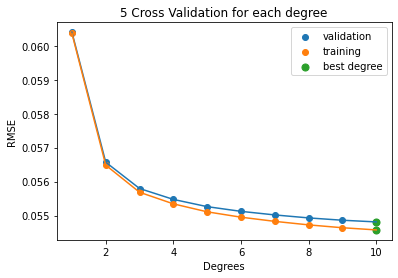

In [29]:
x_values_val = []
y_values_val = []
x_values_test = []
y_values_test = []

# plot the raw observations
for deg in range(1,max_deg+1):
  if deg != best_deg:
    x_values_val.append(deg)
    y_values_val.append(analysis_multi_poly_val[deg][0])
    x_values_test.append(deg)
    y_values_test.append(analysis_multi_poly_train[deg][0])

plt.scatter(x_values_val, y_values_val, label='validation')
plt.scatter(x_values_test, y_values_test, label='training')
plt.scatter([least_poly]*2, [analysis_multi_poly_val[least_poly][0], analysis_multi_poly_train[least_poly][0]], label='best degree', s = 50)

# plot the trend line with error bars that correspond to standard deviation
Mean_val = np.array([np.mean(value) for deg,value in sorted(errors_multi_poly_val.items())])
Mean_train = np.array([np.mean(value) for deg,value in sorted(errors_multi_poly_train.items())])

plt.errorbar(list(range(1,max_deg+1)), Mean_val)
plt.errorbar(list(range(1,max_deg+1)), Mean_train)

plt.title('5 Cross Validation for each degree')
plt.xlabel('Degrees')
plt.ylabel('RMSE')
plt.legend()
plt.show()